## packages and imports

In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import time
from pathlib import Path

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)

# trunk network parameters
num_bases = 10
num_trunk_epochs = 6000
lr = 1e-3
num_LBFGS_epochs = 1000
#t_stride = 1
eps = 1e-8 # to prevent loss overflow



print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



W0000 00:00:1770212049.794149 35382048 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1770212049.816309 35382048 service.cc:145] XLA service 0x308278070 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770212049.816323 35382048 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1770212049.817916 35382048 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1770212049.817928 35382048 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [2]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [3]:
# load external dataset
# NOTE we're loading t, and subsampling every t_stride steps
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n,t,x)

# disabled functionality for train/test split for now
n_samp = len(data)
train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.2, random_state = seed)
u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])



grid is (t,x) =  201 201


In [4]:
#u_train, s_train = u,s
print('label dataset size is (n, coord) = ', u_train.shape)
print('input dataset size is (n, x, t) = ', s_train.shape)

output_tr = jnp.transpose(s_train, axes=(1,2,0)) 
print(f"subsampled dataset size is (t,x,n) = {output_tr.shape}")

label dataset size is (n, coord) =  (352, 2)
input dataset size is (n, x, t) =  (352, 201, 201)
subsampled dataset size is (t,x,n) = (201, 201, 352)


In [8]:
tt,xx = jnp.meshgrid(t_grid, x_grid)
tx_grid = jnp.concatenate([tt.flatten()[:,None], xx.flatten()[:,None]], axis=1) #xt_grid[:,1] is x, xt_grid[:,0] is t
print("tx_grid is of shape (n, coord) = ",tx_grid.shape)

tx_grid is of shape (n, coord) =  (40401, 2)


## initializing model, loss_fn

In [9]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (num_bases, output_tr.shape[2])) # now A_model is a 2x2 matrix
print("A_model is shape  = ", A_model.shape)


T_MAT = jax.vmap(trunk_model)(tx_grid)
print(T_MAT.shape)
model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(trunk_model)(tx_grid)
    pred_y = T_MAT @ A_model
    # Reshape pred_y to match output_tr's 3D shape
    pred_y_3d = pred_y.reshape(len(t_grid), len(x_grid), -1)  # (T, X, N)
    return jnp.mean((output_tr - pred_y_3d) ** 2)  # Simple MSE

A_model is shape  =  (10, 352)
(40401, 10)


In [10]:
%%time
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

s_time = time.time()
start_time = time.time()
for step in range(num_trunk_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 10 == 0: # new carriage print, avoid tqdm for memory
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}, {end_time-start_time:.2f}s", end="", flush=True)
        start_time = time.time()
e_time = time.time()
print(f"\nfinal adam loss: {loss:.3e}, total time: {e_time-s_time:.2f}s\n")

opt = optax.lbfgs()

for step in range(num_LBFGS_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss))
    if step % 100 == 0:
        print(
            f"\r{' ' * 80}\rLBFGS step {step}: loss={float(loss):.3e}",
            end="",
            flush=True
        )

Adam step 5990: loss=8.188e-04, 0.13s
final adam loss: 8.179e-04, total time: 80.10s

LBFGS step 900: loss=7.227e-04                                                  CPU times: user 16.8 s, sys: 4.57 s, total: 21.4 s
Wall time: 1min 32s


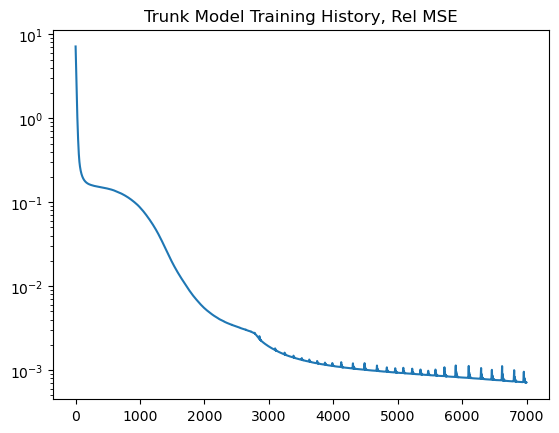

In [11]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, MSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [12]:
trunk_model, A_model = model
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
T_MAT = jax.vmap(trunk_model)(tx_grid)
print("T_MAT is shape (t*x,n) = ", T_MAT.shape)

T_MAT is shape (t*x,n) =  (40401, 10)


In [14]:
# take QR of T_MAT which is just a matrix
Q_MAT, R_MAT = scipy.linalg.qr(T_MAT, mode = 'economic')

    
print(f"Q_MAT is of shape (t*x,n) = {Q_MAT.shape}")
print(f"R_MAT is of shape {R_MAT.shape}")
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

Q_MAT is of shape (t*x,n) = (40401, 10)
R_MAT is of shape (10, 10)
shapes agree? True


## save out Q,R factors and data

In [16]:
save_path = Path("qr_factors.npz")

# export data to .npz arrays
np.savez_compressed(
    save_path,
    Q = np.asarray(Q_MAT),
    R = np.asarray(R_MAT),
    t_grid = np.asarray(t_grid),
    x_grid = np.asarray(x_grid)
)

print("exported to:", save_path)

exported to: qr_factors.npz


## branch network training

In [30]:
# %%
K = A_model.shape[0]  # number of basis functions = 10
N = A_model.shape[1]  # number of samples = 352

# define architectures for component networks
branch_arch = [u_train.shape[1], 60, 60, K]  # Input: u (2,), Output: K (10)

key, subkey_t, subkey_A = jax.random.split(key, num=3)
branch_model = MLP(branch_arch, key=subkey_t)

B_MAT = jax.vmap(branch_model)(u_train)  # Shape: (352, 10)
print("Branch Model is shape:", B_MAT.shape)

# RA_model should match B_MAT shape: (N, K) = (352, 10)
RA_model = (R_MAT @ A_model).T  # Transpose to get (352, 10)
print("RA_Model is shape:", RA_model.shape)

# Verify shapes match
print(f"B_MAT shape: {B_MAT.shape}, RA_model shape: {RA_model.shape}")
print(f"Shapes match: {B_MAT.shape == RA_model.shape}")

Branch Model is shape: (352, 10)
RA_Model is shape: (352, 10)
B_MAT shape: (352, 10), RA_model shape: (352, 10)
Shapes match: True


In [31]:

RA_target = jnp.asarray(RA_model)  # (T, K, N), frozen data

def branch_loss_fn(branch_model, RA_target, u_train, eps=1e-8): # vmap u_train (parameters) and t_grid through branch model -- loss is B_NN - R^*A^*
    B_MAT= jax.vmap( branch_model)(u_train) 
    return jnp.mean((B_MAT - RA_target) ** 2)

# ---- optimizer ----


@eqx.filter_jit # does require filter value and grad because of frozen RA target
def branch_train_step(branch_model, opt_state, RA_target, u_train, t_grid):
    loss, grads = eqx.filter_value_and_grad(branch_loss_fn)( 
        branch_model, RA_target, u_train, t_grid
    )
    updates, opt_state = opt.update(grads, opt_state, branch_model)
    branch_model = eqx.apply_updates(branch_model, updates)
    return branch_model, opt_state, loss



In [32]:
%%time
branch_loss_hist = []

opt = optax.adam(lr)

# IMPORTANT: init on branch_model only
opt_state = opt.init(eqx.filter(branch_model, eqx.is_inexact_array))

for step in range(num_trunk_epochs):
    branch_model, opt_state, loss = branch_train_step(
        branch_model, opt_state, RA_target, u_train, t_grid
    )
    branch_loss_hist.append(float(loss))
    if step % 10 == 0:
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}",
              end="", flush=True)

opt = optax.lbfgs()

for step in range(num_LBFGS_epochs):
    branch_model, opt_state, loss = branch_train_step(branch_model, opt_state, RA_target, u_train, t_grid)
    branch_loss_hist.append(float(loss))
    if step % 10 == 0:
        end_time = time.time()
        print(f"\rLBFGS step {step}: loss={float(loss):.3e}",
              end="", flush=True)



print(f"\nfinal adam loss: {float(loss):.3e}\n")

LBFGS step 990: loss=4.309e-01
final adam loss: 4.309e-01

CPU times: user 7.97 s, sys: 2.33 s, total: 10.3 s
Wall time: 14.8 s


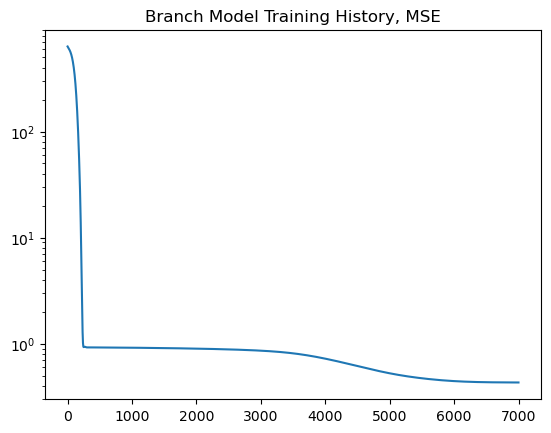

In [33]:
plt.plot(branch_loss_hist)
plt.title(f"Branch Model Training History, MSE")
plt.yscale('log')

In [34]:
u_rand, s_rand = u_train[20], s_train[20] # s is true values, u is input parameters

def compute_QHb_grid(Q_MAT, branch_model, u, t_grid):
    """
    Q_MAT: (T*X, K) storing Q flattened
    u: (u_dim,)
    returns: (T, X) with entries Q(t,x)^T * b(u)
    """
    # Get branch output for this u
    b = branch_model(u)  # Shape: (K,)
    
    # Compute Q @ b to get flattened predictions
    pred_flat = Q_MAT @ b  # Shape: (T*X,)
    
    # Reshape to (T, X) grid
    pred_grid = pred_flat.reshape(len(t_grid), len(x_grid))  # Shape: (T, X)
    return pred_grid

# Example usage
u_rand = u_train[20]
rand_pred_tx = compute_QHb_grid(Q_MAT, branch_model, u_rand, t_grid)
print(f"Prediction shape: {rand_pred_tx.shape}")  # Should be (201, 201)

Prediction shape: (201, 201)


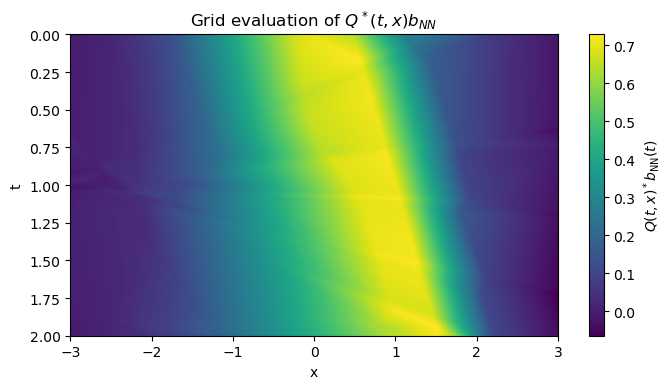

In [37]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $Q^*(t,x)b_{NN}$")
plt.tight_layout()
plt.show()


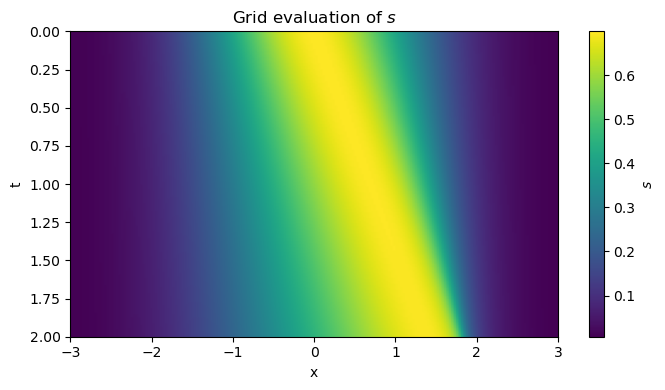

In [36]:
plt.figure(figsize=(7, 4))
plt.imshow(
    s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$s$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $s$")
plt.tight_layout()
plt.show()


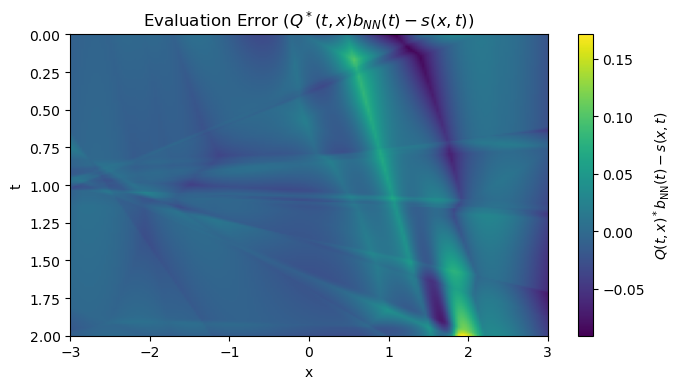

In [38]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx - s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t) - s(x,t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Evaluation Error ($Q^*(t,x)b_{NN}(t) - s(x,t)$)")
plt.tight_layout()
plt.show()
